In [1]:
import numpy as np
import pandas as pd
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import logging
import os
import warnings
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger('prophet').setLevel(logging.ERROR)
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, GRU, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_absolute_error
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from fbprophet.forecaster import Prophet

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import datetime

### Drop Duplicate (pick max usage per hour)

In [2]:
# Pick the max values hourly and drop the rest 
df = pd.read_csv('data/raw/municipality_bus_utilization.csv')
df['timestamp'] = df['timestamp'].apply(lambda date: datetime.datetime.strptime(date[:date.find(':')] + ':00:00', "%Y-%m-%d %H:%M:%S"))
df = df.sort_values(['timestamp', 'municipality_id', 'usage']).drop_duplicates(['timestamp', 'municipality_id'], keep='last')

In [3]:
df[:5]

,timestamp,municipality_id,usage,total_capacity
3,2017-06-04 07:00:00,0,204,2813
7,2017-06-04 07:00:00,1,129,397
6,2017-06-04 07:00:00,2,273,697
9,2017-06-04 07:00:00,3,623,1930
2,2017-06-04 07:00:00,4,1090,3893


### Drop Total Capacity

In [4]:
# We wont be using total capacity for this one. Since 
# we will train models for each municipality seperately, 
# total cap will be stay same for each data
df = df.drop('total_capacity', axis=1)

### Missing Days

In [5]:
# We found our missing dates. We will deal with those later
def find_missing_dates(df):
    tempdf = df.copy()
    tempdf = tempdf['timestamp'].apply(lambda date: datetime.datetime.strptime(str(date)[:str(date).find(' ')], "%Y-%m-%d"))
    missing_dates = pd.date_range(start="2017-06-04", end="2017-08-19").difference(tempdf.values)
    return missing_dates

missing_dates = find_missing_dates(df)
missing_dates

DatetimeIndex(['2017-06-20', '2017-06-21', '2017-07-31', '2017-08-03',
               '2017-08-04'],
              dtype='datetime64[ns]', freq=None)

### Recorded Hours

In [6]:
# from this given example, we should have 10 recorded hours per day
temp = df[['timestamp', 'municipality_id']].set_index('timestamp')
temp[temp['municipality_id'] == 0].loc['2017-06-04'].index

DatetimeIndex(['2017-06-04 07:00:00', '2017-06-04 08:00:00',
               '2017-06-04 09:00:00', '2017-06-04 10:00:00',
               '2017-06-04 11:00:00', '2017-06-04 12:00:00',
               '2017-06-04 13:00:00', '2017-06-04 14:00:00',
               '2017-06-04 15:00:00', '2017-06-04 16:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [7]:
rec_hours = temp[temp['municipality_id'] == 0].loc['2017-06-04'].index.hour
rec_hours

Int64Index([7, 8, 9, 10, 11, 12, 13, 14, 15, 16], dtype='int64', name='timestamp')

### Missing Values

In [8]:
# no inbalanced missing data
temp.value_counts()

municipality_id
0                  674
1                  674
2                  674
3                  674
4                  674
5                  674
6                  674
7                  674
8                  674
9                  674
dtype: int64

In [9]:
def find_missing_hours(df):
    df = df[['timestamp', 'municipality_id']].set_index('timestamp').copy()
    
    missing = {}
    for day in pd.date_range('2017-06-04', '2017-08-19'):
        # find the missing hours of corresponding days
        hrs = temp[temp['municipality_id'] == 0].loc[str(day.date())].index.hour.to_list()
        missing_hours = set(rec_hours.to_list()).difference(hrs)
        missing[str(day.date())] = missing_hours

    return missing


missing_hours = find_missing_hours(df)
missing_hours

{'2017-06-04': set(),
 '2017-06-05': set(),
 '2017-06-06': set(),
 '2017-06-07': {7},
 '2017-06-08': set(),
 '2017-06-09': {7},
 '2017-06-10': {7},
 '2017-06-11': {7},
 '2017-06-12': {7},
 '2017-06-13': set(),
 '2017-06-14': {7},
 '2017-06-15': {7},
 '2017-06-16': {7},
 '2017-06-17': {7},
 '2017-06-18': {7},
 '2017-06-19': {7},
 '2017-06-20': {7, 8, 9, 10, 11, 12, 13, 14, 15, 16},
 '2017-06-21': {7, 8, 9, 10, 11, 12, 13, 14, 15, 16},
 '2017-06-22': set(),
 '2017-06-23': set(),
 '2017-06-24': set(),
 '2017-06-25': {7},
 '2017-06-26': set(),
 '2017-06-27': set(),
 '2017-06-28': {7},
 '2017-06-29': set(),
 '2017-06-30': set(),
 '2017-07-01': {7},
 '2017-07-02': set(),
 '2017-07-03': {7},
 '2017-07-04': {7},
 '2017-07-05': {7},
 '2017-07-06': {7},
 '2017-07-07': {7},
 '2017-07-08': set(),
 '2017-07-09': {7},
 '2017-07-10': {7},
 '2017-07-11': {7},
 '2017-07-12': {7},
 '2017-07-13': {7},
 '2017-07-14': {7},
 '2017-07-15': set(),
 '2017-07-16': {7},
 '2017-07-17': {7},
 '2017-07-18': {7},
 '

In [10]:
def fill_missing_records(df, missing_hours, rec_hours):
    temp = df[['timestamp', 'municipality_id']].set_index('timestamp').copy()
    
    # collect the missing date records (hours included)
    missing_dates = []
    for day in pd.date_range('2017-06-04', '2017-08-19'):
        new_date = [day.replace(hour=hour) for hour in missing_hours[str(day.date())]]
        missing_dates.extend(new_date)
        
    # create a dataframe of the missing data
    missing_muni = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] * len(missing_dates)
    missing_dates = sorted(missing_dates*10)
    missing_usage = [np.nan] * len(missing_muni)  # usages will be filled with the means of corresponding hours later
    missing_df = pd.DataFrame(data={'timestamp': missing_dates, 
                                    'municipality_id': missing_muni, 
                                    'usage': missing_usage})
    
    return missing_df

    
missing_df = fill_missing_records(df, missing_hours, rec_hours)
missing_df

,timestamp,municipality_id,usage
0,2017-06-07 07:00:00,0,NaN
1,2017-06-07 07:00:00,1,NaN
2,2017-06-07 07:00:00,2,NaN
3,2017-06-07 07:00:00,3,NaN
4,2017-06-07 07:00:00,4,NaN
...,...,...,...
955,2017-08-19 07:00:00,5,NaN
956,2017-08-19 07:00:00,6,NaN
957,2017-08-19 07:00:00,7,NaN
958,2017-08-19 07:00:00,8,NaN


In [11]:
# means of each hour for each municipality
means = {}
for muni in df['municipality_id'].unique():
    temp = df[df['municipality_id'] == muni].set_index('timestamp')
    for hr in rec_hours:
        means[f'{muni}_{hr}'] = np.mean(temp[temp.index.hour == hr]['usage'])
        print(f"Municipality: {muni} Hour: {hr} Usage Mean: {np.mean(temp[temp.index.hour == hr]['usage'])}")

Municipality: 0 Hour: 7 Usage Mean: 229.92307692307693
Municipality: 0 Hour: 8 Usage Mean: 310.6666666666667
Municipality: 0 Hour: 9 Usage Mean: 440.52777777777777
Municipality: 0 Hour: 10 Usage Mean: 548.6111111111111
Municipality: 0 Hour: 11 Usage Mean: 620.2222222222222
Municipality: 0 Hour: 12 Usage Mean: 660.4305555555555
Municipality: 0 Hour: 13 Usage Mean: 682.4305555555555
Municipality: 0 Hour: 14 Usage Mean: 686.1111111111111
Municipality: 0 Hour: 15 Usage Mean: 654.5
Municipality: 0 Hour: 16 Usage Mean: 588.5416666666666
Municipality: 1 Hour: 7 Usage Mean: 134.15384615384616
Municipality: 1 Hour: 8 Usage Mean: 161.84722222222223
Municipality: 1 Hour: 9 Usage Mean: 231.05555555555554
Municipality: 1 Hour: 10 Usage Mean: 296.5
Municipality: 1 Hour: 11 Usage Mean: 340.0416666666667
Municipality: 1 Hour: 12 Usage Mean: 359.0833333333333
Municipality: 1 Hour: 13 Usage Mean: 368.25
Municipality: 1 Hour: 14 Usage Mean: 366.40277777777777
Municipality: 1 Hour: 15 Usage Mean: 352.9027

In [12]:
# set the index to timestamp and fill the none values
missing_df = missing_df.set_index('timestamp')
for muni in df['municipality_id'].unique():
    for hr in rec_hours:
        missing_df[(missing_df['municipality_id'] == muni) & (missing_df.index.hour == hr)] = missing_df[(missing_df['municipality_id'] == muni) & (missing_df.index.hour == hr)].fillna(means[f'{muni}_{hr}'])

In [13]:
final_df = pd.concat((df.set_index('timestamp'), missing_df))
final_df = final_df.sort_index()
final_df

,municipality_id,usage
timestamp,,
2017-06-04 07:00:00,0,204.0
2017-06-04 07:00:00,1,129.0
2017-06-04 07:00:00,2,273.0
2017-06-04 07:00:00,3,623.0
2017-06-04 07:00:00,4,1090.0
...,...,...
2017-08-19 16:00:00,4,2779.0
2017-08-19 16:00:00,5,239.0
2017-08-19 16:00:00,6,1727.0


### Seperate Data by Municipality

In [14]:
for muni in final_df['municipality_id'].unique():  
    final_df[final_df['municipality_id'] == muni].to_csv(f'data/preprocessed/municipality_{muni}.csv', index=True)

### Municipalities

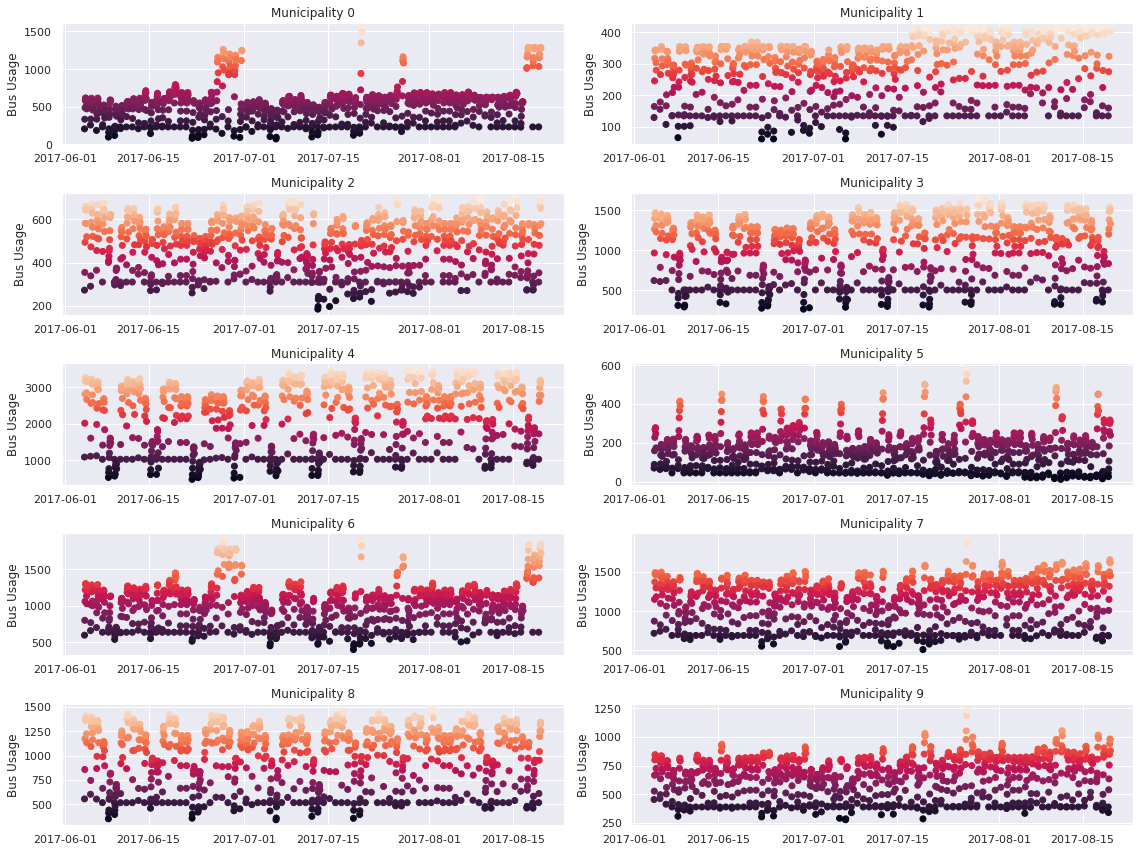

In [15]:
# overview of the data with respect to their municipalities
fig, ax = plt.subplots(5, 2, figsize=(16, 12))

muni_count = 0
for i in range(5):
    for j in range(2):
        df = pd.read_csv(f'data/preprocessed/municipality_{muni_count}.csv').drop('municipality_id', axis=1)
        df['timestamp'] = df['timestamp'].apply(lambda date: datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S"))
        df = df.set_index('timestamp')

        ax[i][j].scatter(df.index, df['usage'], c=df['usage'])
        ax[i][j].set_title(f'Municipality {muni_count}')
        ax[i][j].set_ylabel('Bus Usage')
        
        muni_count += 1
    
plt.tight_layout()

### Define Helper Functions

In [16]:
# prepare data to train, test and evaluate
def prep_data(df, scaler):
    """
    returns series_train, series_test, series
    """
    df['usage'] = np.asarray(df['usage'].astype('float32'))
    
    df_train = df[df.index < '2017-08-06']
    df_test = df[df.index > '2017-08-06']
    
    series_train = df_train['usage'].to_numpy()  # first 630 val (from 2017.06.04 07:00:00 to 2017.08.05 16:00:00 )
    series_test = df_test['usage'].to_numpy()  # last 140 val (from 2017.08.06 07:00:00 to 2017.08.19 16:00:00)

    series_train = scaler.fit_transform(series_train.reshape(-1, 1))
    series_test = scaler.transform(series_test.reshape(-1, 1))

    series = np.append(series_train, series_test)  # all
    return series_train, series_test, series


# compare the prediction with actuals
def get_score(y_pred, y_actual, is_scaled=False):
    """
    y_pred: predictions as list
    y_actial: actual values as np.array
    """
    if is_scaled:
        y_pred = scaler.inverse_transform(np.asarray(y_pred, dtype=np.float32).astype('float32').reshape(-1, 1)).flatten()
        y_actual = scaler.inverse_transform(y_actual.reshape(-1, 1)).flatten()
    
    mse = mean_squared_error(y_pred, y_actual)
    mae = mean_absolute_error(y_pred, y_actual)
    rmse = math.sqrt(mse)
    return mae, mse, rmse


# this function will be used for tf-keras models if we do multi-step predictions
def forecast(model, to_be_predicted, n=1):
    """
    forecast the next `n` number of records
    """
    predicted = []
    for i in range(n):
        pred = model.predict(np.asarray(to_be_predicted, dtype=np.float32).astype('float32').reshape(-1, 10, 1))
        pred = pred.flatten()[0]
        to_be_predicted.append(pred)
        predicted.append(pred)
        to_be_predicted.pop(0)
    return predicted


# this will give us a brand new dataframe with datetime
def create_df(start_date, end_date):
    forecast_dates = []
    for day in pd.date_range(start_date, end_date):
        new_date = [day.replace(hour=hour) for hour in range(7,17)]
        forecast_dates.extend(new_date)

    forecast_usage = [np.nan] * len(forecast_dates)
    forecast_df = pd.DataFrame(data={'timestamp': sorted(forecast_dates), 
                                     'usage': forecast_usage})
    return forecast_df

### Define Models - RNN/LSTM/GRU

In [17]:
# architectures
def build_RNN():
    i = Input(shape=(10, 1))
    x = SimpleRNN(256, activation='relu', return_sequences=True)(i)
    x = Dropout(0.5)(x)
    x = Dense(1)(x)
    return Model(i, x)


def build_LSTM():
    i = Input(shape=(10, 1))
    x = LSTM(256, activation='relu', return_sequences=True,)(i)
    x = Dropout(0.3)(x)
    x = Dense(1)(x)
    return Model(i, x)


def build_GRU():
    i = Input(shape=(10, 1))
    x = GRU(256, activation='relu', return_sequences=True,)(i)
    x = Dropout(0.5)(x)
    x = Dense(1)(x)
    return Model(i, x)

### Callback

In [18]:
# customize output to print only at the last epoch
class custom_log(Callback):
    def __init__(self, epochs, muni, val=False):
        self.epochs = epochs
        self.muni = muni
        self.val = val
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch == (epochs - 1):
            print(f"Training of Municipality {self.muni} completed:")
            if self.val:
                print(f"Epoch: {epoch} | Loss: {logs['loss']} | Val. Loss: {logs['val_loss']}")
            else:
                print(f"Epoch: {epoch} | Loss: {logs['loss']}")

### Iterative Evaluating - RNN

Training of Municipality 0 completed:
Epoch: 119 | Loss: 0.30586907267570496
Training of Municipality 1 completed:
Epoch: 119 | Loss: 0.16517631709575653
Training of Municipality 2 completed:
Epoch: 119 | Loss: 0.3067888617515564
Training of Municipality 3 completed:
Epoch: 119 | Loss: 0.3330090343952179
Training of Municipality 4 completed:
Epoch: 119 | Loss: 0.3404286503791809
Training of Municipality 5 completed:
Epoch: 119 | Loss: 0.3196878731250763
Training of Municipality 6 completed:
Epoch: 119 | Loss: 0.3361167907714844
Training of Municipality 7 completed:
Epoch: 119 | Loss: 0.21055345237255096
Training of Municipality 8 completed:
Epoch: 119 | Loss: 0.27611687779426575
Training of Municipality 9 completed:
Epoch: 119 | Loss: 0.21319544315338135


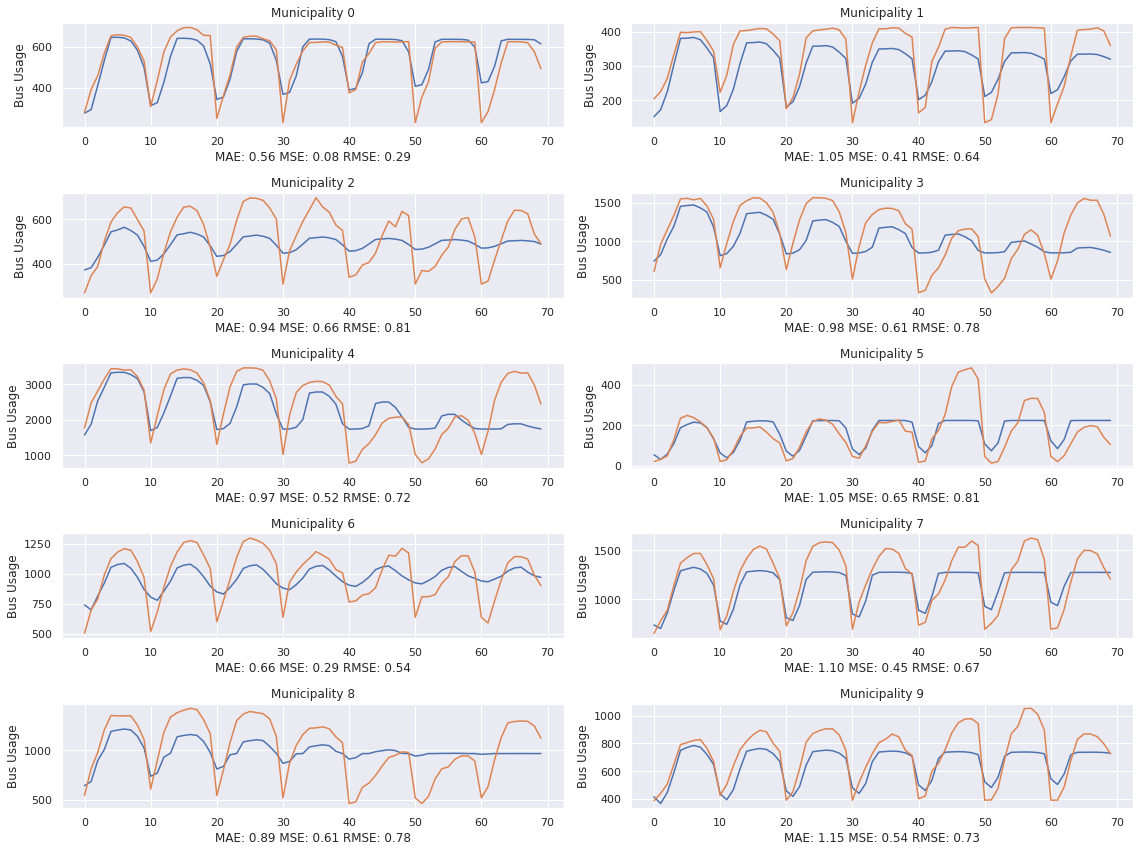

In [19]:
# iterate over the municipalities and evaluate RNN models for each one
fig, ax = plt.subplots(5, 2, figsize=(16, 12))

muni_count = 0
for i in range(5):
    for j in range(2):
        # read dataframe
        df = pd.read_csv(f'data/preprocessed/municipality_{muni_count}.csv').drop('municipality_id', axis=1)
        df['timestamp'] = df['timestamp'].apply(lambda date: datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S"))
        df = df.set_index('timestamp')

        # prepared data for training and evaluating
        scaler = StandardScaler()
        series_train, series_test, series = prep_data(df, scaler)
        generator = TimeseriesGenerator(series_train[:-70], series_train[:-70], length=10, batch_size=32)
        valid_generator = TimeseriesGenerator(series_train[-70:], series_train[-70:], length=10)
        
        # model training
        model = build_RNN()
        model.compile(optimizer=Adam(lr=0.0007), loss='mse')
        epochs = 120
        model.fit(generator, epochs=epochs, validation_data=valid_generator, callbacks=[custom_log(epochs, muni_count)], verbose=0)
        
        # evaluating
        y_pred = forecast(model=model, to_be_predicted=list(series_train[-10:]), n=70)
        mae, mse, rmse = get_score(y_pred, series_test[:70])
        
        # inverse scaling the get real values
        y_pred = scaler.inverse_transform(np.asarray(y_pred, dtype=np.float32).astype('float32').reshape(-1, 1)).flatten()
        y_actual = scaler.inverse_transform(series_test[:70].reshape(-1, 1)).flatten()
        
        # plotting
        ax[i][j].plot(y_pred)
        ax[i][j].plot(y_actual)
        ax[i][j].set_title(f'Municipality {muni_count}')
        ax[i][j].set_ylabel('Bus Usage')
        ax[i][j].set_xlabel('MAE: {:.2f} MSE: {:.2f} RMSE: {:.2f}'.format(np.mean(mae), np.mean(mse), np.mean(rmse)))
        
        muni_count += 1
    
plt.tight_layout()

### Iterative Evaluating - LSTM

Training of Municipality 0 completed:
Epoch: 119 | Loss: 0.3400198519229889
Training of Municipality 1 completed:
Epoch: 119 | Loss: 0.16791725158691406
Training of Municipality 2 completed:
Epoch: 119 | Loss: 0.3661855459213257
Training of Municipality 3 completed:
Epoch: 119 | Loss: 0.3539887070655823
Training of Municipality 4 completed:
Epoch: 119 | Loss: 0.3742717206478119
Training of Municipality 5 completed:
Epoch: 119 | Loss: 0.3330966532230377
Training of Municipality 6 completed:
Epoch: 119 | Loss: 0.3706088960170746
Training of Municipality 7 completed:
Epoch: 119 | Loss: 0.22275766730308533
Training of Municipality 8 completed:
Epoch: 119 | Loss: 0.2762697637081146
Training of Municipality 9 completed:
Epoch: 119 | Loss: 0.21990177035331726


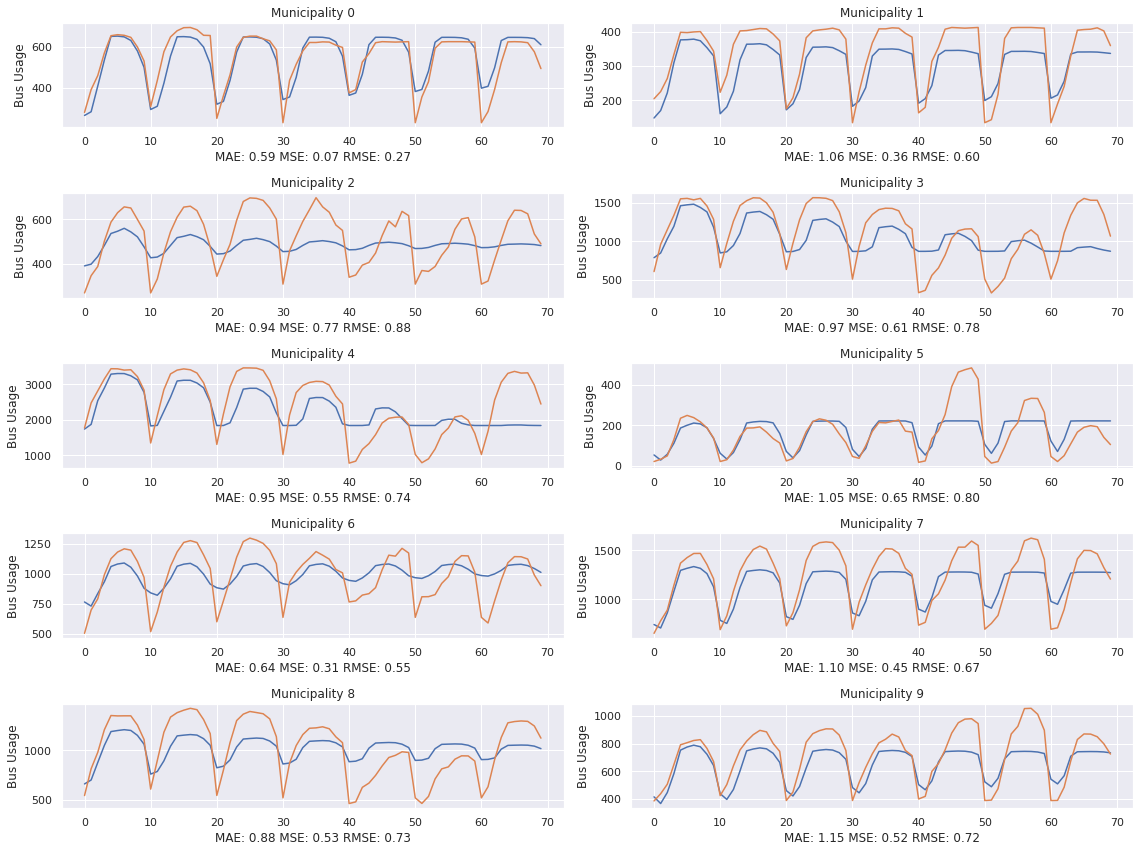

In [20]:
# iterate over the municipalities and evaluate LSTM models for each one
fig, ax = plt.subplots(5, 2, figsize=(16, 12))

muni_count = 0
for i in range(5):
    for j in range(2):
        # read dataframe
        df = pd.read_csv(f'data/preprocessed/municipality_{muni_count}.csv').drop('municipality_id', axis=1)
        df['timestamp'] = df['timestamp'].apply(lambda date: datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S"))
        df = df.set_index('timestamp')

        # prepared data for training and evaluating
        scaler = StandardScaler()
        series_train, series_test, series = prep_data(df, scaler)
        generator = TimeseriesGenerator(series_train[:-70], series_train[:-70], length=10, batch_size=32)
        valid_generator = TimeseriesGenerator(series_train[-70:], series_train[-70:], length=10)
        
        # model training
        model = build_LSTM()
        model.compile(optimizer=Adam(lr=0.0007), loss='mse')
        epochs = 120
        model.fit(generator, epochs=epochs, validation_data=valid_generator, callbacks=[custom_log(epochs, muni_count)], verbose=0)
        
        # evaluating
        y_pred = forecast(model=model, to_be_predicted=list(series_train[-10:]), n=70)
        mae, mse, rmse = get_score(y_pred, series_test[:70])
        
        # inverse scaling to get real values
        y_pred = scaler.inverse_transform(np.asarray(y_pred, dtype=np.float32).astype('float32').reshape(-1, 1)).flatten()
        y_actual = scaler.inverse_transform(series_test[:70].reshape(-1, 1)).flatten()
        
        # plotting
        ax[i][j].plot(y_pred)
        ax[i][j].plot(y_actual)
        ax[i][j].set_title(f'Municipality {muni_count}')
        ax[i][j].set_ylabel('Bus Usage')
        ax[i][j].set_xlabel('MAE: {:.2f} MSE: {:.2f} RMSE: {:.2f}'.format(np.mean(mae), np.mean(mse), np.mean(rmse)))
        
        muni_count += 1
    
plt.tight_layout()

### Iterative Evaluating - GRU

Training of Municipality 0 completed:
Epoch: 119 | Loss: 0.3409835696220398
Training of Municipality 1 completed:
Epoch: 119 | Loss: 0.17515745759010315
Training of Municipality 2 completed:
Epoch: 119 | Loss: 0.3691934049129486
Training of Municipality 3 completed:
Epoch: 119 | Loss: 0.3514992594718933
Training of Municipality 4 completed:
Epoch: 119 | Loss: 0.3768690526485443
Training of Municipality 5 completed:
Epoch: 119 | Loss: 0.3354327380657196
Training of Municipality 6 completed:
Epoch: 119 | Loss: 0.38394346833229065
Training of Municipality 7 completed:
Epoch: 119 | Loss: 0.2288413941860199
Training of Municipality 8 completed:
Epoch: 119 | Loss: 0.2925473749637604
Training of Municipality 9 completed:
Epoch: 119 | Loss: 0.22620385885238647


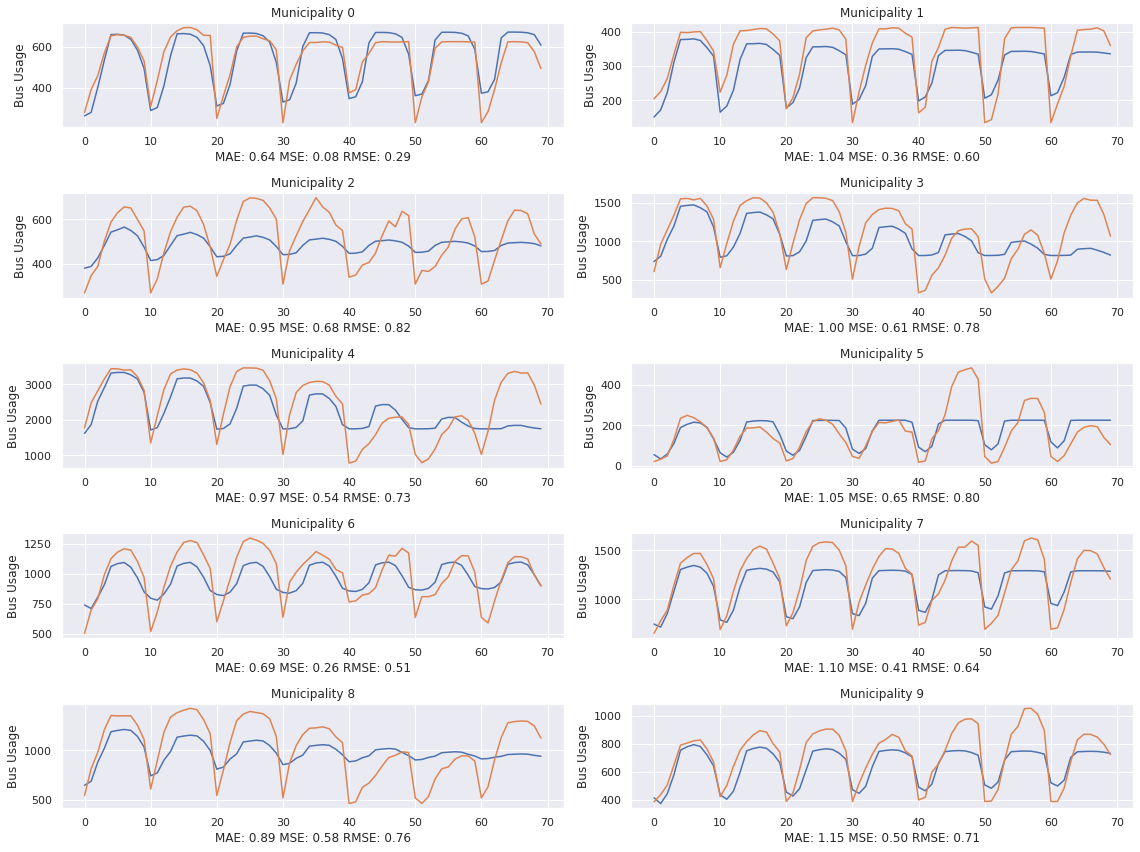

In [21]:
# iterate over the municipalities and evaluate GRU models for each one
fig, ax = plt.subplots(5, 2, figsize=(16, 12))

muni_count = 0
for i in range(5):
    for j in range(2):
        # read dataframe
        df = pd.read_csv(f'data/preprocessed/municipality_{muni_count}.csv').drop('municipality_id', axis=1)
        df['timestamp'] = df['timestamp'].apply(lambda date: datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S"))
        df = df.set_index('timestamp')

        # prepared data for training and evaluating
        scaler = StandardScaler()
        series_train, series_test, series = prep_data(df, scaler)
        generator = TimeseriesGenerator(series_train[:-70], series_train[:-70], length=10, batch_size=32)
        valid_generator = TimeseriesGenerator(series_train[-70:], series_train[-70:], length=10)
        
        # model training
        model = build_GRU()
        model.compile(optimizer=Adam(lr=0.0007), loss='mse')
        epochs = 120
        model.fit(generator, epochs=epochs, validation_data=valid_generator, callbacks=[custom_log(epochs, muni_count)], verbose=0)
        
        # evaluating
        y_pred = forecast(model=model, to_be_predicted=list(series_train[-10:]), n=70)
        mae, mse, rmse = get_score(y_pred, series_test[:70])
    
        # inverse scaling to get real values
        y_pred = scaler.inverse_transform(np.asarray(y_pred, dtype=np.float32).astype('float32').reshape(-1, 1)).flatten()
        y_actual = scaler.inverse_transform(series_test[:70].reshape(-1, 1)).flatten()
        
        # plotting
        ax[i][j].plot(y_pred)
        ax[i][j].plot(y_actual)
        ax[i][j].set_title(f'Municipality {muni_count}')
        ax[i][j].set_ylabel('Bus Usage')
        ax[i][j].set_xlabel('MAE: {:.2f} MSE: {:.2f} RMSE: {:.2f}'.format(np.mean(mae), np.mean(mse), np.mean(rmse)))
        
        muni_count += 1
    
plt.tight_layout()

### First Degree Diff

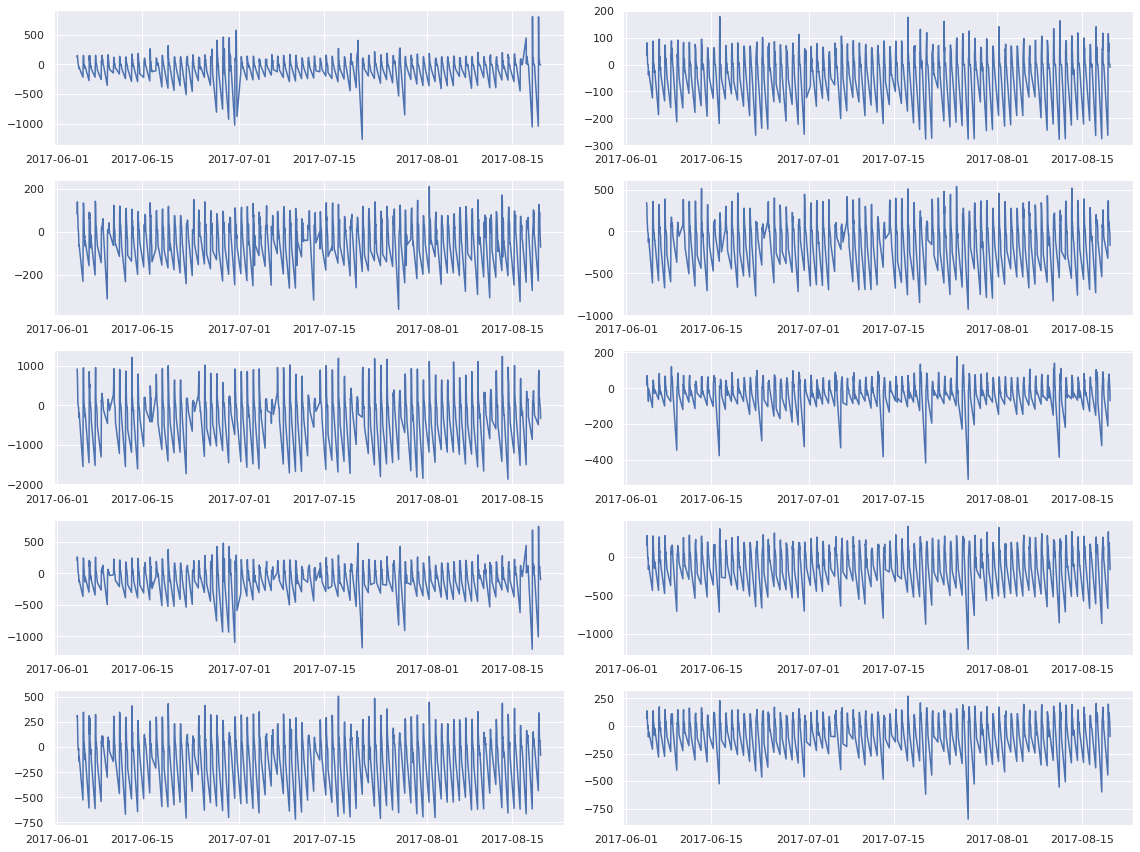

In [22]:
# find some optimal value for d (in this case, there arent much difference between the degrees)
fig, ax = plt.subplots(5, 2, figsize=(16, 12))

muni_count = 0
for i in range(5):
    for j in range(2):
        # read dataframe
        df = pd.read_csv(f'data/preprocessed/municipality_{muni_count}.csv').drop('municipality_id', axis=1)
        df['timestamp'] = df['timestamp'].apply(lambda date: datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S"))
        df = df.set_index('timestamp')
        
        ax[i][j].plot(df['usage'].diff())
 
        muni_count += 1
    
plt.tight_layout()

### Second Degree Diff

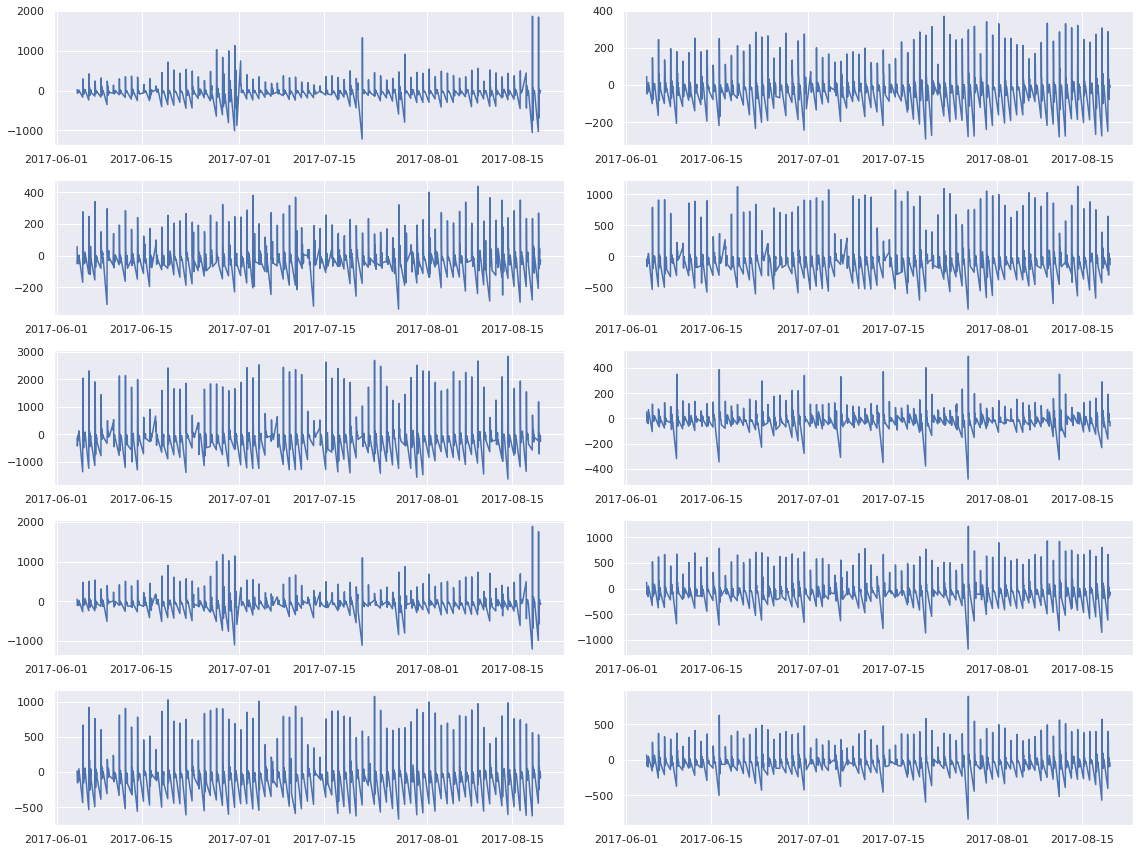

In [23]:
fig, ax = plt.subplots(5, 2, figsize=(16, 12))

muni_count = 0
for i in range(5):
    for j in range(2):
        # read dataframe
        df = pd.read_csv(f'data/preprocessed/municipality_{muni_count}.csv').drop('municipality_id', axis=1)
        df['timestamp'] = df['timestamp'].apply(lambda date: datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S"))
        df = df.set_index('timestamp')
        
        ax[i][j].plot(df['usage'].diff().diff())
 
        muni_count += 1
    
plt.tight_layout()

### Iterative Evaluating - ARIMA

/home/canarch/anaconda3/envs/jotform/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/canarch/anaconda3/envs/jotform/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/canarch/anaconda3/envs/jotform/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/canarch/anaconda3/envs/jotform/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/canarc

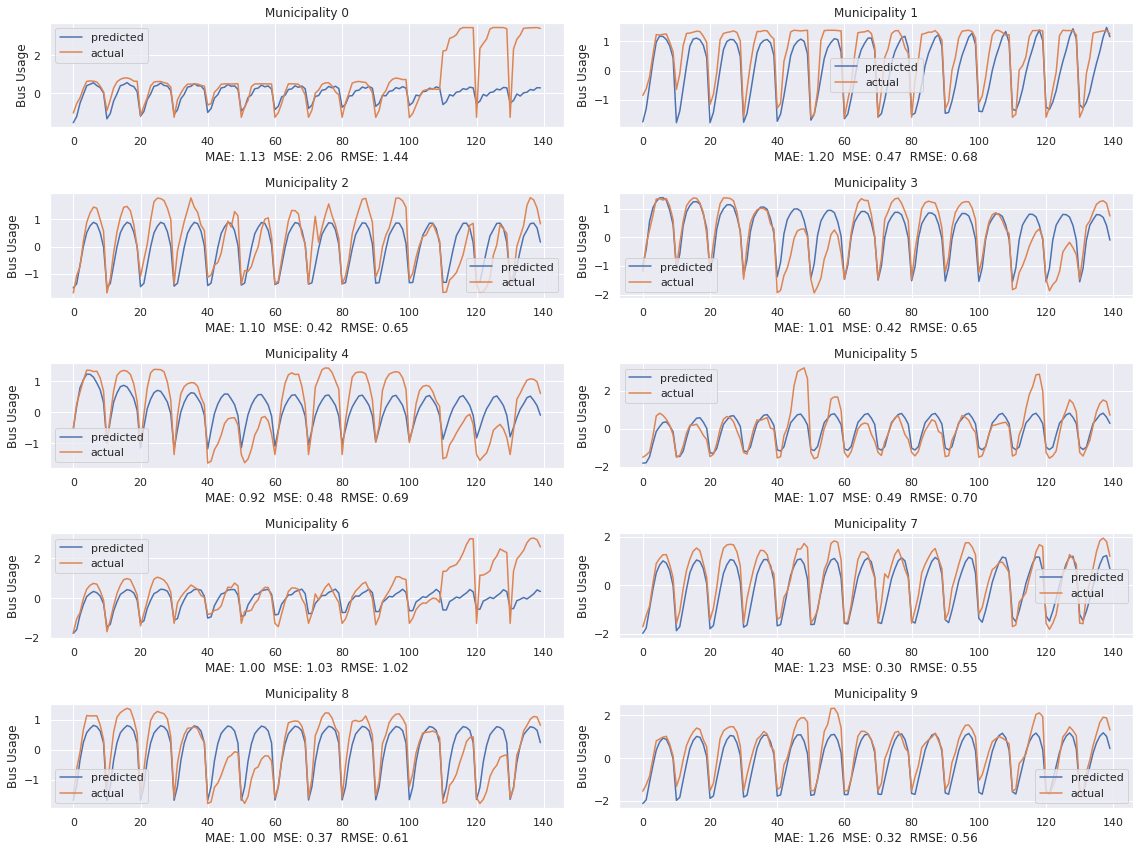

In [24]:
# find some optimal value for d (in this case, there arent much difference between the degrees)
fig, ax = plt.subplots(5, 2, figsize=(16, 12))

muni_count = 0
for i in range(5):
    for j in range(2):
        # read dataframe
        df = pd.read_csv(f'data/preprocessed/municipality_{muni_count}.csv').drop('municipality_id', axis=1)
        df['timestamp'] = df['timestamp'].apply(lambda date: datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S"))
        df = df.set_index('timestamp')
        
        # prepared data for training and evaluating
        scaler = StandardScaler()
        series_train, series_test, series = prep_data(df, scaler)
        
        # train ARIMA model
        arima_model = ARIMA(series_train, order=(10, 0, 9))
        model = arima_model.fit()
        
        # forecast
        y_pred = model.forecast(140)
        y_actual = series_test
        
        # evaluate
        mae, mse, rmse = get_score(y_pred, y_actual)
        
        # plotting
        ax[i][j].plot(y_pred, label='predicted')
        ax[i][j].plot(series_test, label='actual')
        ax[i][j].set_title(f'Municipality {muni_count}')
        ax[i][j].set_ylabel('Bus Usage')
        ax[i][j].set_xlabel('MAE: {:.2f}  MSE: {:.2f}  RMSE: {:.2f}'.format(np.mean(mae), np.mean(mse), np.mean(rmse)))
        ax[i][j].legend()
        
        muni_count += 1
    
plt.tight_layout()

### Iterative Evaluating - Facebook Prophet

In [25]:
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

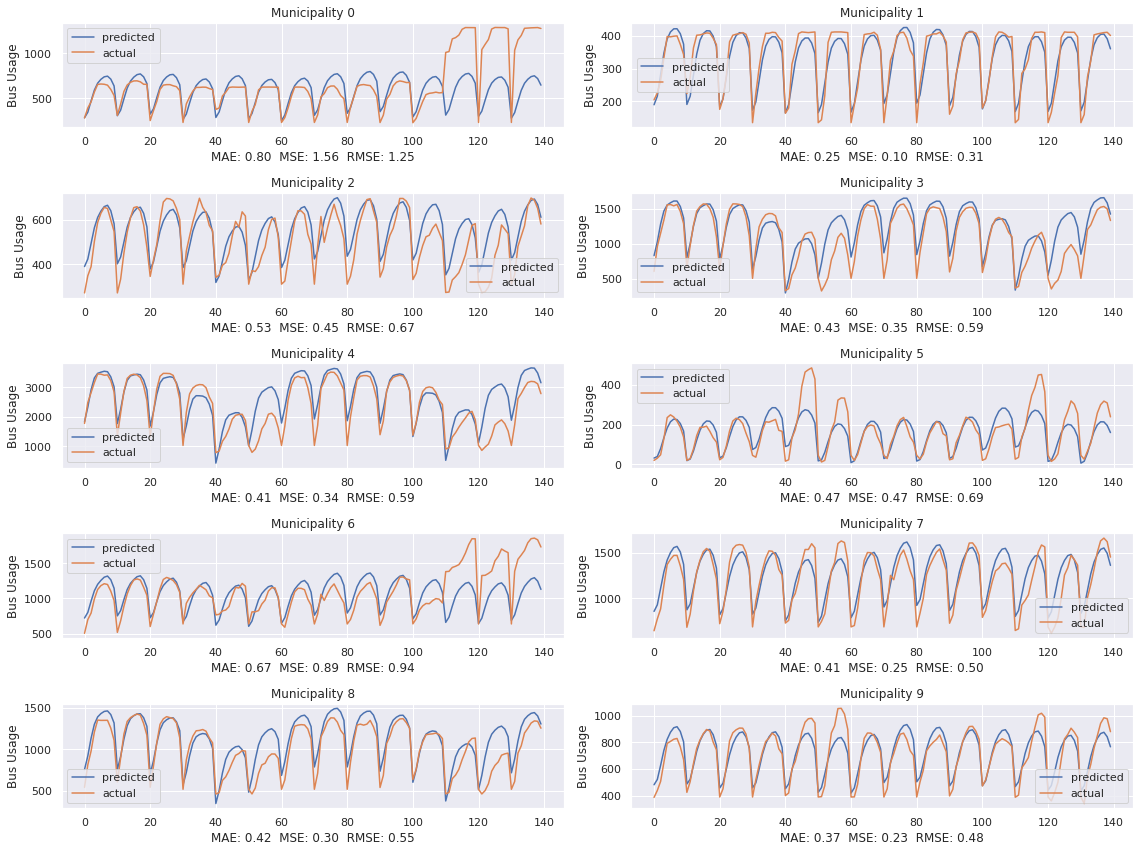

In [26]:
fig, ax = plt.subplots(5, 2, figsize=(16, 12))

muni_count = 0
for i in range(5):
    for j in range(2):
        # read dataframe
        df = pd.read_csv(f'data/preprocessed/municipality_{muni_count}.csv').drop('municipality_id', axis=1)
        df['timestamp'] = df['timestamp'].apply(lambda date: datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S"))
        df = df.set_index('timestamp')
        
        # prepared data for training and evaluating
        scaler = StandardScaler()
        series_train, series_test, series = prep_data(df, scaler)
            
        # train prophet
        fp = Prophet(daily_seasonality=True, yearly_seasonality=False)
        df_train = df[df.index < '2017-08-06']
        df_test = df[df.index > '2017-08-06']
        df_train_fp = df_train.reset_index()
        df_train_fp.columns = ['ds', 'y']
        with suppress_stdout_stderr():
            fp.fit(df_train_fp)
        
        # forecast
        df_test_fp = df_test.reset_index().drop('usage', axis=1)
        df_test_fp.columns = ['ds']
        fpforecast = fp.predict(df_test_fp)
        
        # evaluate
        mae, mse, rmse = get_score(scaler.transform(fpforecast['yhat'].to_numpy().reshape(-1, 1)), series_test)
        y_actual = scaler.inverse_transform(series_test.reshape(-1, 1)).flatten()
        
        # plotting
        ax[i][j].plot(fpforecast['yhat'], label='predicted')
        ax[i][j].plot(y_actual, label='actual')
        ax[i][j].set_title(f'Municipality {muni_count}')
        ax[i][j].set_ylabel('Bus Usage')
        ax[i][j].set_xlabel('MAE: {:.2f}  MSE: {:.2f}  RMSE: {:.2f}'.format(np.mean(mae), np.mean(mse), np.mean(rmse)))
        ax[i][j].legend()
        
        muni_count += 1
    
plt.tight_layout()

---

We got the best results with Facebook Prophet, so we wil use it for our future predictions.

---

### Forecasting with Facebook Prophet

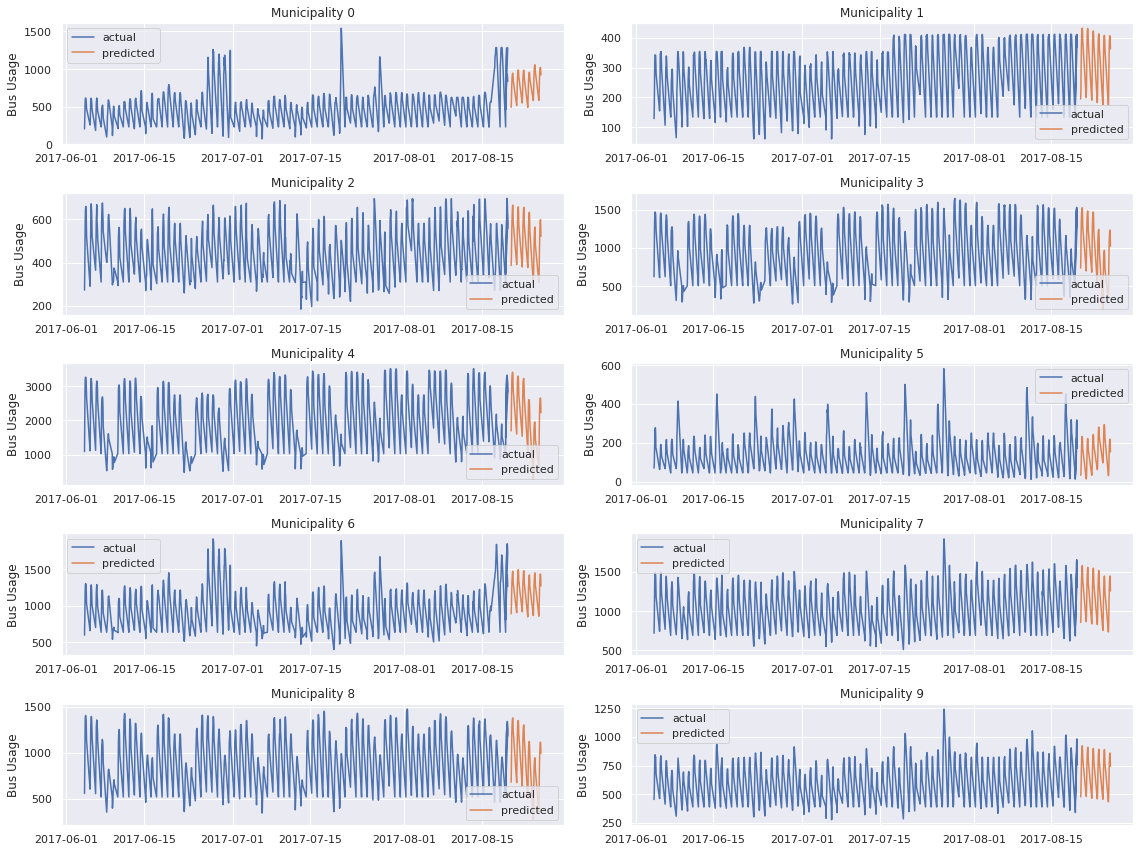

In [27]:
fig, ax = plt.subplots(5, 2, figsize=(16, 12))

muni_count = 0
for i in range(5):
    for j in range(2):
        # read dataframe
        df = pd.read_csv(f'data/preprocessed/municipality_{muni_count}.csv').drop('municipality_id', axis=1)
        df['timestamp'] = df['timestamp'].apply(lambda date: datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S"))
        df = df.set_index('timestamp')
        
        # prepared data for training and evaluating
        scaler = StandardScaler()
        series_train, series_test, series = prep_data(df, scaler)
            
        # train prophet
        fp = Prophet(daily_seasonality=True, yearly_seasonality=False)
        df_train_fp = df.reset_index()
        df_train_fp.columns = ['ds', 'y']
        with suppress_stdout_stderr():
            fp.fit(df_train_fp)
        
        # forecast
        forecast_df = create_df('2017-08-19', '2017-08-25').set_index('timestamp')
        df_test_fp = forecast_df.reset_index().drop('usage', axis=1)
        df_test_fp.columns = ['ds']
        fpforecast = fp.predict(df_test_fp)
        
        # save forecasting
        forecast_df['usage'] = np.around(fpforecast['yhat'].to_numpy())
        final_df = pd.concat((df, forecast_df))
        final_df.to_csv(f'data/forecast/forecast_{muni_count}.csv', index=True)
        
        # plot
        ax[i][j].plot(final_df[final_df.index < '2017-08-20'], label='actual')
        ax[i][j].plot(final_df[final_df.index > '2017-08-20'], label='predicted')
        ax[i][j].set_title(f'Municipality {muni_count}')
        ax[i][j].set_ylabel('Bus Usage')
        ax[i][j].legend()
        
        muni_count += 1
    
plt.tight_layout()